#Description

To evaluate the effectiveness of our approach, we used 90 percent of the WRDS dataset that had been cleaned using the K-Fold approach as a train set. The remaining 10 percent of the dataset, which had not been cleaned and was immediately saved, was used as a test set. We utilized the sentence transformer, specifically the 'all-mpnet-base-v2' model, to embed the descriptions in the training set. We then fed this embedded set into the OneVsRestClassifier, which employed the Support Vector Classifier (SVC) model as an estimator, utilizing the default radial basis function (rbf) kernel and default number of iterations. The resulting model was then tested using the aforementioned test set, which was also embedded using the same sentence transformer.

To further evaluate the performance of our model, we also tested it on a Kaggle dataset containing company descriptions and their proper sectors.

Additionally, we conducted a comparison between our model and ChatGPT in classifying the company descriptions using the OpenAI API. It's important to note that ChatGPT had prior knowledge about the companies mentioned in the company descriptions (from their names), which could have introduced bias in its predictions.

#Preprocessing the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv("/content/drive/MyDrive/ninety_percent.csv")
data.head()

,Sector Name,Sector Index,Description
0,Health Care,35,"Sutura, Inc. designs, develops, and manufactur..."
1,Materials,15,"Terra Nostra Resources Corp., through its subs..."
2,Information Technology,45,"Dot Hill Systems Corp. designs, manufactures, ..."
3,Information Technology,45,CentralSquare Technologies provides software p...
4,Energy,10,"On October 12, 2021, ATP Oil & Gas Corp. went ..."


In [ ]:
gics_sector={10: "Energy", 15: "Materials", 20: "Industrials", 25: "Consumer Discretionary (Consumer Cyclical)", 30: "Consumer Staples (Consumer Defensive)", 35: "Health Care", 40: "Financials", 45: "Information Technology", 50: "Communication Services", 55: "Utilities", 60: "Real Estate"}
gics_industry_group={1010: "Energy", 1510: "Materials", 2010: "Capital Goods", 2020: "Commercial & Professional Services", 2030: "Transportation", 2510: "Automobiles & Components", 2520: "Consumer Durables & Apparel", 2530: "Consumer Services", 2550: "Retailing", 3010: "Food & Staples Retailing", 3020: "Food, Beverage & Tobacco", 3030: "Household & Personal Products", 3510: "Health Care Equipment & Services", 3520: "Pharmaceuticals, Biotechnology  & Life Sciences", 4010: "Banks", 4020: "Diversified Financials", 4030: "Insurance", 4510: "Software & Services", 4520: "Technology Hardware & Equipment", 4530: "Semiconductors & Semiconductor Equipment", 5010: "Telecommunication Services", 5020: "Media & Entertainment", 5510: "Utilities", 6010: "Real Estate"}
gics_industry = {101010: "Energy Equipment & Services", 101020: "Oil, Gas & Consumable Fuels", 151010: "Chemicals", 151020: "Construction Materials", 151030: "Containers & Packaging", 151040: "Metals & Mining", 151050: "Paper & Forest Products", 201010: "Aerospace & Defense", 201020: "Building Products", 201030: "Construction & Engineering", 201040: "Electrical Equipment", 201050: "Industrial Conglomerates", 201060: "Machinery", 201070: "Trading Companies & Distributors", 202010: "Commercial Services & Supplies", 202020: "Professional Services", 203010: "Air Freight & Logistics", 203020: "Airlines", 203030: "Marine", 203040: "Road & Rail", 203050: "Transportation Infrastructure", 251010: "Auto Components", 251020: "Automobiles", 252010: "Household Durables", 252020: "Leisure Products", 252030: "Textiles, Apparel & Luxury Goods", 253010: "Hotels, Restaurants & Leisure", 253020: "Diversified Consumer Services", 255010: "Distributors", 255020: "Internet & Direct Marketing Retail", 255030: "Multiline Retail", 255040: "Specialty Retail", 301010: "Food & Staples Retailing", 302010: "Beverages", 302020: "Food Products", 302030: "Tobacco", 303010: "Household Products", 303020: "Personal Products", 351010: "Health Care Equipment & Supplies", 351020: "Health Care Providers & Services", 351030: "Health Care Technology", 352010: "Biotechnology", 352020: "Pharmaceuticals", 352030: "Life Sciences Tools & Services", 401010: "Banks", 401020: "Thrifts & Mortgage Finance", 402010: "Diversified Financial Services", 402020: "Consumer Finance", 402030: "Capital Markets", 402040: "Mortgage Real Estate Investment Trusts (REITs)", 403010: "Insurance", 451020: "IT Services", 451030: "Software", 452010: "Communications Equipment", 452020: "Technology Hardware, Storage & Peripherals", 452030: "Electronic Equipment, Instruments & Components", 453010: "Semiconductors & Semiconductor Equipment", 501010: "Diversified Telecommunication Services", 501020: "Wireless Telecommunication Services", 502010: "Media", 502020: "Entertainment", 502030: "Interactive Media & Services", 551010: "Electric Utilities", 551020: "Gas Utilities", 551030: "Multi-Utilities", 551040: "Water Utilities", 551050: "Independent Power and Renewable Electricity Producers", 601010: "Equity Real Estate Investment Trusts (REITs)", 601020: "Real Estate Management & Development"}
##############We do not have data for sub industry###############################
gics_sub_industry={10101010: "Oil & Gas Drilling", 10101020: "Oil & Gas Equipment & Services", 10102010: "Integrated Oil & Gas", 10102020: "Oil & Gas Exploration & Production", 10102030: "Oil & Gas Refining & Marketing", 10102040: "Oil & Gas Storage & Transportation", 10102050: "Coal & Consumable Fuels", 15101010: "Commodity Chemicals", 15101020: "Diversified Chemicals", 15101030: "Fertilizers & Agricultural Chemicals", 15101040: "Industrial Gases", 15101050: "Specialty Chemicals", 15102010: "Construction Materials", 15103010: "Metal & Glass Containers", 15103020: "Paper Packaging", 15104010: "Aluminum", 15104020: "Diversified Metals & Mining", 15104025: "Copper", 15104030: "Gold", 15104040: "Precious Metals & Minerals", 15104045: "Silver", 15104050: "Steel", 15105010: "Forest Products", 15105020: "Paper Products", 20101010: "Aerospace & Defense", 20102010: "Building Products", 20103010: "Construction & Engineering", 20104010: "Electrical Components & Equipment", 20104020: "Heavy Electrical Equipment", 20105010: "Industrial Conglomerates", 20106010: "Construction Machinery & Heavy Trucks", 20106015: "Agricultural & Farm Machinery", 20106020: "Industrial Machinery", 20107010: "Trading Companies & Distributors", 20201010: "Commercial Printing", 20201050: "Environmental & Facilities Services", 20201060: "Office Services & Supplies", 20201070: "Diversified Support Services", 20201080: "Security & Alarm Services", 20202010: "Human Resource & Employment Services", 20202020: "Research & Consulting Services", 20301010: "Air Freight & Logistics", 20302010: "Airlines", 20303010: "Marine", 20304010: "Railroads", 20304020: "Trucking", 20305010: "Airport Services", 20305020: "Highways & Railtracks", 20305030: "Marine Ports & Services", 25101010: "Auto Parts & Equipment", 25101020: "Tires & Rubber", 25102010: "Automobile Manufacturers", 25102020: "Motorcycle Manufacturers", 25201010: "Consumer Electronics", 25201020: "Home Furnishings", 25201030: "Homebuilding", 25201040: "Household Appliances", 25201050: "Housewares & Specialties", 25202010: "Leisure Products", 25203010: "Apparel, Accessories & Luxury Goods", 25203020: "Footwear", 25203030: "Textiles", 25301010: "Casinos & Gaming", 25301020: "Hotels, Resorts & Cruise Lines", 25301030: "Leisure Facilities", 25301040: "Restaurants", 25302010: "Education Services", 25302020: "Specialized Consumer Services", 25501010: "Distributors", 25502020: "Internet & Direct Marketing Retail", 25503010: "Department Stores", 25503020: "General Merchandise Stores", 25504010: "Apparel Retail", 25504020: "Computer & Electronics Retail", 25504030: "Home Improvement Retail", 25504040: "Specialty Stores", 25504050: "Automotive Retail", 25504060: "Homefurnishing Retail", 30101010: "Drug Retail", 30101020: "Food Distributors", 30101030: "Food Retail", 30101040: "Hypermarkets & Super Centers", 30201010: "Brewers", 30201020: "Distillers & Vintners", 30201030: "Soft Drinks", 30202010: "Agricultural Products", 30202030: "Packaged Foods & Meats", 30203010: "Tobacco", 30301010: "Household Products", 30302010: "Personal Products", 35101010: "Health Care Equipment", 35101020: "Health Care Supplies", 35102010: "Health Care Distributors", 35102015: "Health Care Services", 35102020: "Health Care Facilities", 35102030: "Managed Health Care", 35103010: "Health Care Technology", 35201010: "Biotechnology", 35202010: "Pharmaceuticals", 35203010: "Life Sciences Tools & Services", 40101010: "Diversified Banks", 40101015: "Regional Banks", 40102010: "Thrifts & Mortgage Finance", 40201020: "Other Diversified Financial Services", 40201030: "Multi-Sector Holdings", 40201040: "Specialized Finance", 40202010: "Consumer Finance", 40203010: "Asset Management & Custody Banks", 40203020: "Investment Banking & Brokerage", 40203030: "Diversified Capital Markets", 40203040: "Financial Exchanges & Data", 40204010: "Mortgage REITs", 40301010: "Insurance Brokers", 40301020: "Life & Health Insurance", 40301030: "Multi-line Insurance", 40301040: "Property & Casualty Insurance", 40301050: "Reinsurance", 45102010: "IT Consulting & Other Services", 45102020: "Data Processing & Outsourced Services", 45102030: "Internet Services & Infrastructure", 45103010: "Application Software", 45103020: "Systems Software", 45201020: "Communications Equipment", 45202030: "Technology Hardware, Storage & Peripherals", 45203010: "Electronic Equipment & Instruments", 45203015: "Electronic Components", 45203020: "Electronic Manufacturing Services", 45203030: "Technology Distributors", 45301010: "Semiconductor Equipment", 45301020: "Semiconductors", 50101010: "Alternative Carriers", 50101020: "Integrated Telecommunication Services", 50102010: "Wireless Telecommunication Services", 50201010: "Advertising", 50201020: "Broadcasting", 50201030: "Cable & Satellite", 50201040: "Publishing", 50202010: "Movies & Entertainment", 50202020: "Interactive Home Entertainment", 50203010: "Interactive Media & Services", 55101010: "Electric Utilities", 55102010: "Gas Utilities", 55103010: "Multi-Utilities", 55104010: "Water Utilities", 55105010: "Independent Power Producers & Energy Traders", 55105020: "Renewable Electricity", 60101010: "Diversified REITs", 60101020: "Industrial REITs", 60101030: "Hotel & Resort REITs", 60101040: "Office REITs", 60101050: "Health Care REITs", 60101060: "Residential REITs", 60101070: "Retail REITs", 60101080: "Specialized REITs", 60102010: "Diversified Real Estate Activities", 60102020: "Real Estate Operating Companies", 60102030: "Real Estate Development", 60102040: "Real Estate Services"}

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data["Sector Index"] = encoder.fit_transform(data["Sector Index"])
data["Sector Index"].value_counts()

6     4353
5     3847
7     3822
3     3028
1     2968
0     2222
2     2034
4      943
8      541
9      504
10     221
Name: Sector Index, dtype: int64

In [ ]:
my_tags = list(gics_sector.values())
len(my_tags)

11

#Embedding the train set

In [ ]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 69.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=33949884bd883a7792e49219d909a5556e3fe8de9ba8c0b4478ea70b1022bcd1
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
X_train = model.encode(list(data["Description"]))

In [ ]:
Y_train = list(data["Sector Index"])

#Training the model

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier(SVC())

clf.fit(X_train, Y_train)

OneVsRestClassifier(estimator=SVC())

#Importing the test set

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/ten_percent.csv")
test.head()

,Sector Index,Description
0,255040,"Vibra Energia S.A. manufactures, processes, di..."
1,551020,"Minnesota Gas Company, formerly known as Cente..."
2,201010,Howmet Aerospace Inc. provides advanced engine...
3,151040,Kingsgate Chile NL engages in the exploration ...
4,253010,"Colonial Holdings, Inc. operates, through its ..."


In [ ]:
import math

temp = []
for item in list(test["Sector Index"]):
  temp.append(math.floor(item/10000))

test["Sector Index"] = temp

In [ ]:
test.head()

,Sector Index,Description
0,25,"Vibra Energia S.A. manufactures, processes, di..."
1,55,"Minnesota Gas Company, formerly known as Cente..."
2,20,Howmet Aerospace Inc. provides advanced engine...
3,15,Kingsgate Chile NL engages in the exploration ...
4,25,"Colonial Holdings, Inc. operates, through its ..."


In [ ]:
test["Sector Index"] = encoder.fit_transform(test["Sector Index"])
test["Sector Index"].value_counts()

6     553
7     551
3     454
5     425
1     404
2     399
0     288
4     128
8     102
9      81
10     49
Name: Sector Index, dtype: int64

#Embedding the test set

In [ ]:
X_test = model.encode(list(test["Description"]))

In [ ]:
Y_test = list(test["Sector Index"])

#Predictions on 10 percent test set

In [ ]:
y_pred = clf.predict(X_test)

#Results from predictions on 10 percent test set

In [ ]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix

print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred, target_names=my_tags))
print("F1 score is: "+ (str)(f1_score(Y_test, y_pred, average='micro')))

[[251  17  10   1   0   0   4   4   0   1   0]
 [  6 353  12   9   7  10   5   2   0   0   0]
 [  5  29 232  30   4  10  14  66   2   7   0]
 [  5  11  26 317  21  10  11  42  11   0   0]
 [  1   6   2  15  83  17   3   1   0   0   0]
 [  1   4   4   3   3 397   4   8   0   1   0]
 [  3   5   5  10   0   8 510   8   0   1   3]
 [  5   5  26  24   0  11  12 462   5   1   0]
 [  0   1   2  20   1   2   1  31  43   0   1]
 [ 17   0   9   1   0   1   2   0   0  51   0]
 [  0   0   3   3   1   0  18   1   0   0  23]]
                                            precision    recall  f1-score   support

                                    Energy       0.85      0.87      0.86       288
                                 Materials       0.82      0.87      0.85       404
                               Industrials       0.70      0.58      0.64       399
Consumer Discretionary (Consumer Cyclical)       0.73      0.70      0.71       454
     Consumer Staples (Consumer Defensive)       0.69      0.

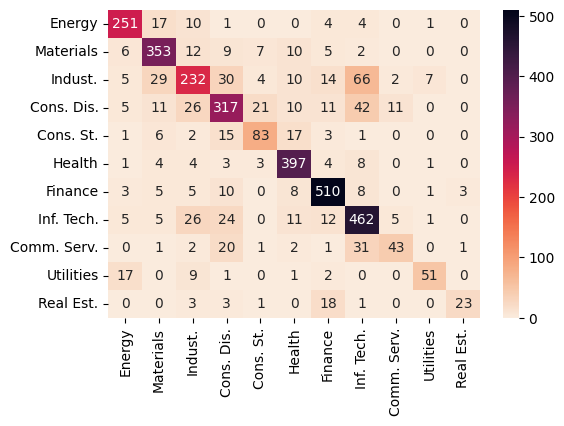

#Importing and preprocessing the Kaggle dataset

In [ ]:
kaggle = pd.read_csv("/content/drive/MyDrive/gics_kaggle.csv")
kaggle.head()

,SectorId,Sector,IndustryGroupId,IndustryGroup,IndustryId,Industry,SubIndustryId,SubIndustry,SubIndustryDescription
0,10,Energy,1010,Energy,101010,Energy Equipment & Services,10101010,Oil & Gas Drilling,Drilling contractors or owners of drilling rig...
1,10,Energy,1010,Energy,101010,Energy Equipment & Services,10101020,Oil & Gas Equipment & Services,"Manufacturers of equipment, including drilling..."
2,10,Energy,1010,Energy,101020,"Oil, Gas & Consumable Fuels",10102010,Integrated Oil & Gas,Integrated oil companies engaged in the explor...
3,10,Energy,1010,Energy,101020,"Oil, Gas & Consumable Fuels",10102020,Oil & Gas Exploration & Production,Companies engaged in the exploration and produ...
4,10,Energy,1010,Energy,101020,"Oil, Gas & Consumable Fuels",10102030,Oil & Gas Refining & Marketing,Companies engaged in the refining and marketin...


In [ ]:
X_kaggle_test = list(kaggle["SubIndustryDescription"])
Y_kaggle_test = list(kaggle["SectorId"])

#Embedding the kaggle dataset 

In [ ]:
X_kaggle_test = model.encode(X_kaggle_test)

In [ ]:
Y_kaggle_test = encoder.fit_transform(Y_kaggle_test)

#Predictions on Kaggle dataset

In [ ]:
kaggle_pred = clf.predict(X_kaggle_test)

#Results from predictions on the Kaggle dataset

In [ ]:
print(confusion_matrix(Y_kaggle_test, kaggle_pred))
print(classification_report(Y_kaggle_test, kaggle_pred, target_names=my_tags))
print("F1 score is: "+ (str)(f1_score(Y_kaggle_test, kaggle_pred, average='micro')))

[[ 7  0  0  0  0  0  0  0  0  0  0]
 [ 0 16  1  0  0  0  0  0  0  0  0]
 [ 0  1 23  0  0  0  1  0  0  0  0]
 [ 0  0  3 26  0  0  0  0  0  0  0]
 [ 0  1  0  0 10  1  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  0  0]
 [ 0  0  0  6  0  0  0  1  3  0  0]
 [ 1  0  0  0  0  0  0  0  0  5  0]
 [ 0  0  0  1  0  0  4  0  0  0  7]]
                                            precision    recall  f1-score   support

                                    Energy       0.88      1.00      0.93         7
                                 Materials       0.89      0.94      0.91        17
                               Industrials       0.85      0.92      0.88        25
Consumer Discretionary (Consumer Cyclical)       0.79      0.90      0.84        29
     Consumer Staples (Consumer Defensive)       1.00      0.83      0.91        12
                               Health Care       0.91      1.00      0.95        10
              

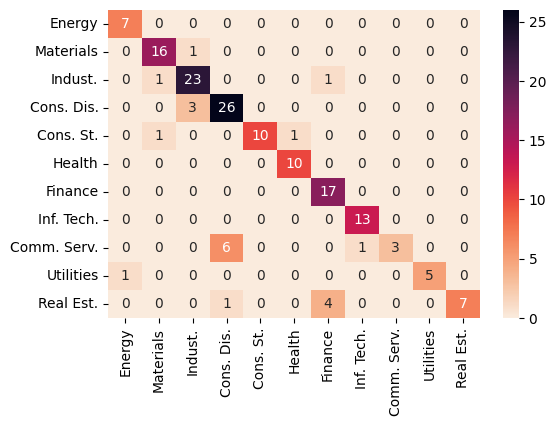

#OpenAI API

In [ ]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.6 MB/s eta 0:00:00


In [ ]:
import openai

openai.api_key = 'your-API-key_here'

In [ ]:
def generate_response(text):
  response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages = [
          {"role": "user", "content": "Your task is to classify a company based on its textual description using GICS. You will classify the sector of the company. Your response shall ONLY be the name of the sector. If you can't classify the company or there isn't enough information, then the response will only be 'None'. The format of the response should only be the name of the sector. Example: 'Energy'. Here is the description: " + text},
      ]
  )
  return response

In [ ]:
def extract_relations(text):
  response = generate_response(text)
  response_string = response['choices'][0].message.content
  response_string = response_string.replace("\n\n", "")
  return response_string

In [ ]:
test_desc = test["Description"]

In [ ]:
import time

gpt_preds = []

#ChatGPT classifying the descriptions from the 10 percent test set

Note: Because of Connection timeout errors, the descriptions were fed into ChatGpt in iterations and all of the results were saved in different .csv files

In [ ]:
for item in test_desc[2636:]:
  gpt_preds.append(extract_relations(item))
  time.sleep(20)

In [ ]:
len(gpt_preds)

798

In [ ]:
gpt_data = pd.DataFrame({
    "GPT predictions": gpt_preds,
})

In [ ]:
gpt_data.shape

(798, 1)

In [ ]:
gpt_data.to_csv("/content/drive/MyDrive/gpt_preds4.csv")

#Merging all .csv files with predictions from ChatGPT



In [ ]:
gpt1 = pd.read_csv("/content/drive/MyDrive/gpt_preds.csv")

In [ ]:
gpt2 = pd.read_csv("/content/drive/MyDrive/gpt_preds2.csv")

In [ ]:
gpt3 = pd.read_csv("/content/drive/MyDrive/gpt_preds3.csv")

In [ ]:
gpt4 = pd.read_csv("/content/drive/MyDrive/gpt_preds4.csv")

In [ ]:
gpt_all = gpt1.append(gpt2).append(gpt3).append(gpt4)

<ipython-input-75-08e781532506>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gpt_all = gpt1.append(gpt2).append(gpt3).append(gpt4)
<ipython-input-75-08e781532506>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gpt_all = gpt1.append(gpt2).append(gpt3).append(gpt4)


In [ ]:
gpt_all.head()

,Unnamed: 0,GPT predictions
0,0,Energy.
1,1,Utilities.
2,2,Industrials.
3,3,Materials.
4,4,Consumer Discretionary.


In [ ]:
gpt_all.shape

(3434, 2)

In [ ]:
final_preds = list(gpt_all["GPT predictions"])

#Editing the results from ChatGPT to match the corresponding names of the sectors

In [ ]:
final_preds_clean = []

for item in final_preds:
  item = item.replace(".", "")
  item = item.replace("sector", "")
  item = item.replace("Sector", "")
  item = item.replace("sectors", "")
  item = item.replace(":", "")
  if "None" in item:
    item = "Can Not Classify"
  if item == "Communications Services":
    item = "Communication Services"
  if item == "Consumer staples":
    item = "Consumer Staples"
  if "Health" in item:
    item = "Health Care"
  if "Industrial" in item:
    item = "Industrials"
  if "belongs" in item:
    item = "Communication Services"
  if item == "Information Technology Services":
    item = "Information Technology"
  if item == "Retailing":
    item = "Consumer Discretionary"
  if item == "Education":
    item = "Consumer Discretionary"
  if item == "Telecommunication Services":
    item = "Communication Services"
  if "Financials" in item:
    item = "Financials"
  if "Environmental" in item:
    item = "Industrials"
  if "Industrail" in item:
    item = "Industrials"
  if item == "Information technology":
    item = "Information Technology"
  if item == "Insurance":
    item = "Financials"
  if "Material" in item:
    item = "Materials"
  if "Mining" in item:
    item = "Materials"
  if "Biotechnology" in item:
    item = "Health Care"
  if "Trusts" in item:
    item = "Real Estate"
  if item == "Technology":
    item = "Information Technology"
  item = item.strip()
  final_preds_clean.append(item)

In [ ]:
set(final_preds_clean)

{'Can Not Classify',
 'Communication Services',
 'Consumer Discretionary',
 'Consumer Staples',
 'Energy',
 'Financials',
 'Health Care',
 'Industrials',
 'Information Technology',
 'Materials',
 'Real Estate',
 'Utilities'}

In [ ]:
len(set(final_preds_clean))

12

In [ ]:
len(final_preds_clean)

3434

In [ ]:
final = pd.read_csv("/content/drive/MyDrive/ten_percent.csv")
final.head()

,Sector Index,Description
0,255040,"Vibra Energia S.A. manufactures, processes, di..."
1,551020,"Minnesota Gas Company, formerly known as Cente..."
2,201010,Howmet Aerospace Inc. provides advanced engine...
3,151040,Kingsgate Chile NL engages in the exploration ...
4,253010,"Colonial Holdings, Inc. operates, through its ..."


In [ ]:
import math

temp = []
for item in list(final["Sector Index"]):
  temp.append(math.floor(item/10000))

final["Sector Index"] = temp

In [ ]:
final.head()

,Sector Index,Description
0,25,"Vibra Energia S.A. manufactures, processes, di..."
1,55,"Minnesota Gas Company, formerly known as Cente..."
2,20,Howmet Aerospace Inc. provides advanced engine...
3,15,Kingsgate Chile NL engages in the exploration ...
4,25,"Colonial Holdings, Inc. operates, through its ..."


In [ ]:
final_test = []

for key in list(final["Sector Index"]):
  final_test.append(gics_sector[key])

In [ ]:
gpt_final_preds_yes = []

for item in final_test:
  if item == "Consumer Staples (Consumer Defensive)":
    gpt_final_preds_yes.append("Consumer Staples")
  elif item == "Consumer Discretionary (Consumer Cyclical)":
    gpt_final_preds_yes.append("Consumer Discretionary")
  else:
    gpt_final_preds_yes.append(item)

#Results from ChatGPT predictions

In [ ]:
print(confusion_matrix(gpt_final_preds_yes, final_preds_clean))
print(classification_report(gpt_final_preds_yes, final_preds_clean))
print("F1 score is: "+ (str)(f1_score(gpt_final_preds_yes, final_preds_clean, average='micro')))

[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [  7  70   2   0   0   1   3   2  15   2   0   0]
 [ 43  67 216   6   2   5  13  63  29   6   4   0]
 [  8   0  14  84   1   1  14   1   0   5   0   0]
 [ 10   0   0   0 241   3   0   7   2  22   1   2]
 [ 46   3   0   0   1 432   6   2   5   4  52   2]
 [ 16   3   0   1   2   1 390   7   1   4   0   0]
 [ 28   1   8   0   8   6   6 271  32  26   3  10]
 [ 25  23   3   0   5   5   8  51 423   6   0   2]
 [ 14   0   2   1   1   0   7  16   1 362   0   0]
 [  1   0   0   0   0   0   0   0   1   0  47   0]
 [  2   0   0   0   5   0   1   2   0   0   0  71]]
                        precision    recall  f1-score   support

      Can Not Classify       0.00      0.00      0.00         0
Communication Services       0.42      0.69      0.52       102
Consumer Discretionary       0.88      0.48      0.62       454
      Consumer Staples       0.91      0.66      0.76       128
                Energy       0.91      0.84      0.87       288
  

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


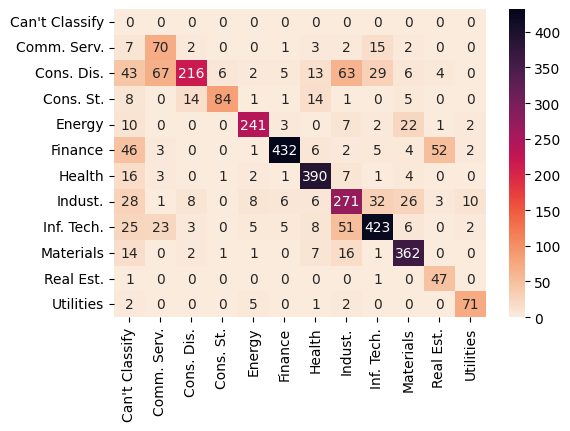